In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [2]:
#import pybullet_envs

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
import numpy as np
import math
import random

In [5]:
import time

In [6]:
def show_state(env, episode,step, info=""):
    plt.figure(99999,figsize=[8,6])
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("episode: {} step: {} ".format(episode,step))
    #plt.title("%s | Step: %d %s" % (env._spec.id,step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [7]:
import gym

In [8]:
use_cuda = torch.cuda.is_available()
device=torch.device("cuda:4" if use_cuda else "cpu")

In [9]:
###### PARAMS ######
learning_rate = 0.01
num_episodes = 1000
gamma=0.99
#gamma=0.85
egreedy = 0.9
egreedy_final = 0.0002
egreedy_decay = 50000

report_interval=10

score_to_solve = 20000

hidden_layer_size=512

In [10]:
env = gym.make('Breakout-ram-v0')
#env = gym.make('AntBulletEnv-v0')

In [28]:
init_obs=env.reset()

In [29]:
print(init_obs)

[ 63  63  63  63  63  63 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 192 192 192 192 192 192
 255 255 255 255 255 255 255 255 255 255 255 255 255 240   0   0 255   0
   0 240   0   5   0   0   6   0  70 182 134 198  22  38  54  70  88   6
 146   0   8   0   0   0   0   0   0 241   0 242   0 242  25 241   5 242
   0   0 255   0 228   0   0   0   0   0   0   0   0   0   0   0   0   0
   8   0 255 255 255 255 255 255 255   0   0   5   0   0 186 214 117 246
 219 242]


In [30]:
init_obs/256.0

array([0.24609375, 0.24609375, 0.24609375, 0.24609375, 0.24609375,
       0.24609375, 0.99609375, 0.99609375, 0.99609375, 0.99609375,
       0.99609375, 0.99609375, 0.99609375, 0.99609375, 0.99609375,
       0.99609375, 0.99609375, 0.99609375, 0.99609375, 0.99609375,
       0.99609375, 0.99609375, 0.99609375, 0.99609375, 0.99609375,
       0.99609375, 0.99609375, 0.99609375, 0.99609375, 0.99609375,
       0.75      , 0.75      , 0.75      , 0.75      , 0.75      ,
       0.75      , 0.99609375, 0.99609375, 0.99609375, 0.99609375,
       0.99609375, 0.99609375, 0.99609375, 0.99609375, 0.99609375,
       0.99609375, 0.99609375, 0.99609375, 0.99609375, 0.9375    ,
       0.        , 0.        , 0.99609375, 0.        , 0.        ,
       0.9375    , 0.        , 0.01953125, 0.        , 0.        ,
       0.0234375 , 0.        , 0.2734375 , 0.7109375 , 0.5234375 ,
       0.7734375 , 0.0859375 , 0.1484375 , 0.2109375 , 0.2734375 ,
       0.34375   , 0.0234375 , 0.5703125 , 0.        , 0.03125

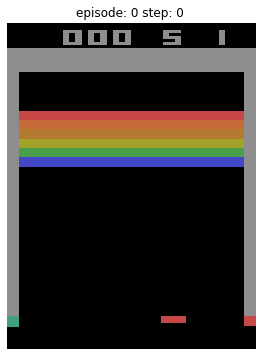

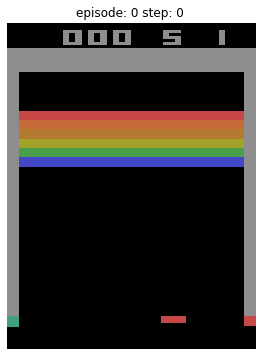

In [13]:
show_state(env,0,0)

In [14]:
env.render()

True

In [15]:
#env = gym.wrappers.Monitor(env, '../mp4/sandbox10',video_callable=lambda episode_id: True,force=True)
env = gym.wrappers.Monitor(env, '../mp4/breakout',video_callable=lambda episode_id: episode_id%10==0,force=True)

In [16]:
number_of_inputs=env.observation_space.shape[0]
number_of_outputs=env.action_space.n

In [17]:
def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon

In [18]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs,hidden_layer_size)
        self.linear2 = nn.Linear(hidden_layer_size,number_of_outputs)
        
        self.activation=nn.Tanh()
        
    def forward(self, x):
        output1 = self.linear1(x)
        output1 = self.activation(output1)
        output2 = self.linear2(output1)
        
        return output2

In [19]:
class QNet_Agent():
    def __init__(self):
        self.nn = NeuralNetwork().to(device)
        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        
    def select_action(self,state,epsilon):
        
        random_for_egreedy=torch.rand(1).item()
        
        if random_for_egreedy>epsilon:
            self.nn.eval()
            with torch.no_grad():
                state=torch.Tensor(state).to(device)
                predicted_value_from_nn=self.nn(state)
                action=torch.argmax(predicted_value_from_nn).item()
        else:
            action=env.action_space.sample()
                
                
        return action
    
    def optimize(self, state, action, new_state, reward, done):
        
        state=torch.Tensor(state).to(device)
        new_state=torch.Tensor(new_state).to(device)
        reward=torch.Tensor([reward]).to(device)
        
        
        if done:
            target_value=reward
        else:
            self.nn.eval()
            new_state_values=self.nn(new_state).detach()
            max_new_state_values=torch.max(new_state_values)
            target_value=reward + gamma*max_new_state_values
        
        self.nn.train()
        #the view call needed to make it a tensor
        predicted_value=self.nn(state)[action].view(-1)
        
        loss=self.loss_function(predicted_value,target_value)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        

In [20]:
qnet_agent=QNet_Agent()

In [21]:
seed_value=23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

In [22]:
%%time

num_episodes=1000

steps_total=np.full([num_episodes],-999,dtype=np.int32)
reward_total=np.full([num_episodes],-999,dtype=np.int32)


frames_total=0

solved_after = 0
solved = False

start_time = time.time()

for i_episode in range(num_episodes):
    
    state = env.reset()
    #for step in range(100):
    step=0
    reward_total[i_episode]=0
    while True:
        
        step+=1
        frames_total += 1
        
        epsilon=calculate_epsilon(frames_total)
        
        #action=env.action_space.sample()
        action=qnet_agent.select_action(state,epsilon)
        
        new_state, reward, done, info = env.step(action)
        reward_total[i_episode]+=reward
        
        qnet_agent.optimize(state,
                            action,
                            new_state,
                            reward,
                            done)
        
        state=new_state
        
        if done:
            steps_total[i_episode]=step
            
            if i_episode>100:
                mean_reward_100 = np.sum(reward_total[i_episode-100:i_episode])/100
            
                if (mean_reward_100 > score_to_solve and solved == False):
                    print("SOLVED! After %i episodes " % i_episode)
                    solved_after = i_episode
                    solved = True
            
            if (i_episode % report_interval == 0 and i_episode>1):
                print("**** Episode  {} **** ".format(i_episode))
                recent_avg_reward=np.average(reward_total[i_episode-report_interval:i_episode])
                print("Recent average reward: {}".format(recent_avg_reward))
                if i_episode>100:
                    print("Reward over last 100: {}".format(mean_reward_100))
                full_avg_so_far=np.average(reward_total[:i_episode])
                print("Average over all episodes so far: {}".format(full_avg_so_far))
                print("epsilon: {}".format(epsilon))
            
                #print("Episode {} finished after: {}".format(i_episode,step))
            break
            
if solved:
    print("Solved after %i episodes" % solved_after)
        

**** Episode  10 **** 
Recent average reward: 1.3
Average over all episodes so far: 1.3
epsilon: 0.8529210880937474
**** Episode  20 **** 
Recent average reward: 2.0
Average over all episodes so far: 1.65
epsilon: 0.8059653059399342
**** Episode  30 **** 
Recent average reward: 1.4
Average over all episodes so far: 1.5666666666666667
epsilon: 0.7648915243850861
**** Episode  40 **** 
Recent average reward: 1.2
Average over all episodes so far: 1.475
epsilon: 0.7304832820038267
**** Episode  50 **** 
Recent average reward: 1.0
Average over all episodes so far: 1.38
epsilon: 0.697888352317981
**** Episode  60 **** 
Recent average reward: 1.0
Average over all episodes so far: 1.3166666666666667
epsilon: 0.6645921193777116
**** Episode  70 **** 
Recent average reward: 1.6
Average over all episodes so far: 1.3571428571428572
epsilon: 0.6339106843212445
**** Episode  80 **** 
Recent average reward: 1.7
Average over all episodes so far: 1.4
epsilon: 0.600501792588086
**** Episode  90 **** 
Re

**** Episode  560 **** 
Recent average reward: 1.5
Reward over last 100: 1.47
Average over all episodes so far: 1.3535714285714286
epsilon: 0.043043438940272565
**** Episode  570 **** 
Recent average reward: 1.4
Reward over last 100: 1.47
Average over all episodes so far: 1.3543859649122807
epsilon: 0.04036004180752946
**** Episode  580 **** 
Recent average reward: 1.6
Reward over last 100: 1.57
Average over all episodes so far: 1.3586206896551725
epsilon: 0.03763074840127012
**** Episode  590 **** 
Recent average reward: 1.4
Reward over last 100: 1.52
Average over all episodes so far: 1.3593220338983052
epsilon: 0.03538403809003137
**** Episode  600 **** 
Recent average reward: 1.1
Reward over last 100: 1.5
Average over all episodes so far: 1.355
epsilon: 0.033125667356269886
**** Episode  610 **** 
Recent average reward: 2.4
Reward over last 100: 1.57
Average over all episodes so far: 1.3721311475409836
epsilon: 0.03047712619611094
**** Episode  620 **** 
Recent average reward: 1.0
R

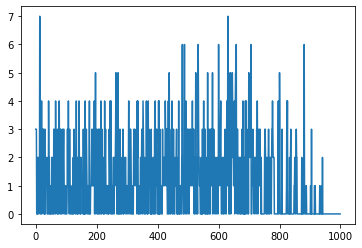

In [27]:
plt.plot(reward_total)
plt.show()

In [24]:
print("Average number of steps: {}". format(np.average(steps_total)))

Average number of steps: 936.527


In [25]:
print("Average number of steps=reward: {}". format(np.average(steps_total)))
print("Average number of steps=reward in last 100 episodes: {}". format(np.average(steps_total[-100:])))



Average number of steps=reward: 936.527
Average number of steps=reward in last 100 episodes: 3743.51


plt.figure(1,figsize=[12,5])
plt.title("Rewards")
plt.bar(torch.arange(len(rewards_total)), rewards_total,alpha=0.6, color='green')
#plt.plot(rewards_total)
plt.show()

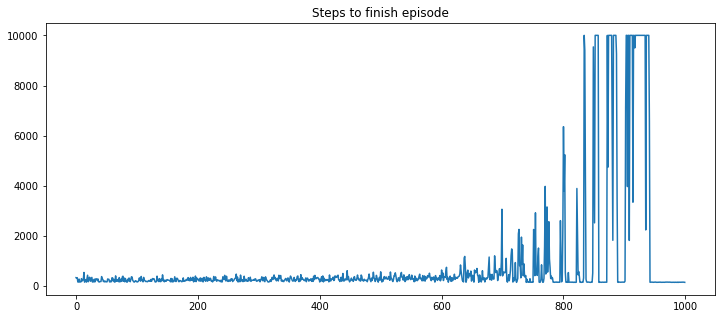

In [26]:
plt.figure(2,figsize=[12,5])
plt.title("Steps to finish episode")
plt.plot(steps_total)
plt.show()